### Проектная работа
## Реализация SGDClassifier (стохастического градиентного спуска) для задачи бинарной классификации с логистической функцией потерь

Рассмотрим задачу бинарной классификации: $X = \{x_i\}$ - признаки, $y = \{y_i\}$ - метки классов -1 и 1.

Определим линейную модель: $a(x) = sign(<w,x> + w_0)$

Добавим к признакам константу, тогда: $a(x) = sign(<w,x>)$

$M_i(w) = y_i <x_i,w>$ - отступ объекта $x_i$ относительно алгоритма $a(x)$

Логистическая функция потерь: $L = log(1+epx(-M))$

$Q(x,w) = \frac{1}{N}\sum{L(M_i(w))} \to min_w$



### Вывод градиента для логистической регрессии:

$M_i = y_i <x_i,w>$

$Q = \frac{1}{N}\sum{log(1+exp(-M_i))}$

$\nabla Q = \frac{1}{N} \frac{e^{-M_i}}{1+e^{-M_i}}y_i x_i = -\frac{1}{N}sigmoid(-M)y_i x_i$

### Градиентный спуск

$w^{(k+1)} = w^{(k)} - \eta_k \nabla Q(X, w)$

$\eta_k = \frac{\alpha}{k^{\beta}}$

Вычислять градиент на каждой итерации может быть трудозатратно. Можно оценить градиент суммы градиентом случайного слагаемого или батчем случайных слагаемых, в таком случае получим Стохастический градиентный спуск

In [22]:
import numpy as np
import scipy
from scipy.special import expit
import pandas as pd


In [23]:
class BinaryLogistic():
    
    def __init__(self, l2_coef=0):
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        M = y * X.dot(w)
        Q = np.logaddexp(0, -1 * M).mean()
        return Q + self.l2_coef / 2 * np.linalg.norm(w)**2
    
    def grad(self, X, y, w):
        M = y * X.dot(w)
        sigmoid = expit(-M)
        return X.T.dot(-y * sigmoid) / y.shape[0] +  self.l2_coef * w

In [24]:
class GDClassifier:

    def __init__(self, alpha=1, beta=0, tolerance=1e-5, max_iter=1000, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.weights = 0
        self.loss = BinaryLogistic(**kwargs)

    def fit(self, X, y, val_X, val_y, verbose=0, w_0=None, metric=None):

        k = 1
        w_pred = w_0
        self.weights = w_pred

        while k <= self.max_iter:

            eta_k = self.alpha / k ** self.beta
            w_curr = w_pred - eta_k * self.loss.grad(X, y, w_pred)
            
            self.weights = w_pred
            if verbose > 0:
                print("epoch: ", k)
                print("current loss: " ,self.loss.func(X, y, w_curr))
                if metric is not None:
                    y_pred = self.predict(val_X)
                    print("metric on validation: ", metric(val_y, y_pred))
            w_pred = w_curr
            k += 1

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype('float') * 2 - 1

    def predict_proba(self, X):
        return expit(X.dot(self.weights))

In [25]:
class SGDClassifier(GDClassifier):
    def __init__(self, batch_size, alpha=1, beta=0,
                 tolerance=1e-7, max_iter=1000, **kwargs):

        self.alpha = alpha
        self.beta = beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.weights = 0
        self.loss = BinaryLogistic(**kwargs)

    def fit(self, X, y, val_X, val_y, w_0=None, verbose=0, log_freq=1, metric=None):
        k = 1
        epoch_diff = 0
        w_pred = w_0
        self.weights = w_pred

        losses = np.array([])
        
        while k <= self.max_iter:

            batch = np.random.choice(range(len(y)), size=self.batch_size)
            eta_k = self.alpha / k ** self.beta
            w_curr = w_pred - eta_k * self.loss.grad(X.iloc[batch], y.iloc[batch], w_pred)
            epoch_diff += self.batch_size / len(y)
            losses = np.append(losses, self.loss.func(X, y, w_curr))
            
            # если 15 раз подряд лосс не падает, закончить
            if len(losses) > 15:
                if np.argsort(losses[-15:])[0] == 0:
                    print(losses[-15:])
                    self.weights = w_curr
                    y_pred = self.predict(val_X)
                    w_pred = w_curr
                    print("early stop")
                    break
            if epoch_diff > log_freq:
                k += 1
                epoch_diff = 0
                self.weights = w_curr
                y_pred = self.predict(val_X)
                if verbose > 0:
                    print("epoch: ", k)
                    print("current loss: ",self.loss.func(X, y, w_curr))
                    if metric is not None:
                        print("metric on validation: ", metric(val_y, y_pred))
            w_pred = w_curr

        self.weights = w_pred

In [26]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
train = train.drop(columns = ["Name", "Ticket", "Cabin"])
test = test.drop(columns = ["Name", "Ticket", "Cabin"])

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


In [30]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [31]:
train = train.dropna()
test = test.dropna()

In [32]:
all_data = [train, test]

In [33]:
for dataset in all_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


In [34]:
y_train = train['Survived']
train = train.drop('Survived', 1)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
train, val, y_train, y_val = train_test_split(train, y_train, stratify=y_train, test_size=0.3)

In [37]:
y_train = y_train * 2 - 1
y_val = y_val * 2 - 1

In [38]:
len(train)

622

In [52]:
clf = SGDClassifier(alpha=1, beta=2, batch_size=200, l2_coef=0.01, max_iter=200)

In [53]:
clf.fit(train, y_train, val, y_val, w_0=np.random.normal(0.1, 0, train.shape[1]), verbose=1, metric=accuracy_score)

epoch:  2
current loss:  38026.99414132361
metric on validation:  0.6179775280898876
epoch:  3
current loss:  6249.287278225345
metric on validation:  0.6142322097378277
epoch:  4
current loss:  1486.7265829671608
metric on validation:  0.38202247191011235
epoch:  5
current loss:  892.6693481713297
metric on validation:  0.38202247191011235
epoch:  6
current loss:  1563.7306030930874
metric on validation:  0.6404494382022472
epoch:  7
current loss:  935.4662875193637
metric on validation:  0.6367041198501873
epoch:  8
current loss:  274.10983757869957
metric on validation:  0.6629213483146067
epoch:  9
current loss:  220.15593864561546
metric on validation:  0.6629213483146067
epoch:  10
current loss:  208.7792808531471
metric on validation:  0.6591760299625468
epoch:  11
current loss:  205.26218937410715
metric on validation:  0.6554307116104869
epoch:  12
current loss:  209.86508075888142
metric on validation:  0.6629213483146067
epoch:  13
current loss:  201.15105521096794
metric on

epoch:  97
current loss:  179.25155549581373
metric on validation:  0.6629213483146067
epoch:  98
current loss:  179.22684759135484
metric on validation:  0.6629213483146067
epoch:  99
current loss:  179.18966760577115
metric on validation:  0.6629213483146067
epoch:  100
current loss:  179.16520246329043
metric on validation:  0.6629213483146067
epoch:  101
current loss:  179.14055816631404
metric on validation:  0.6629213483146067
epoch:  102
current loss:  179.11518411190053
metric on validation:  0.6629213483146067
epoch:  103
current loss:  179.08889573852454
metric on validation:  0.6629213483146067
epoch:  104
current loss:  179.06276635937215
metric on validation:  0.6629213483146067
epoch:  105
current loss:  179.03389181902298
metric on validation:  0.6629213483146067
epoch:  106
current loss:  179.01570560365275
metric on validation:  0.6629213483146067
epoch:  107
current loss:  178.98814901815945
metric on validation:  0.6629213483146067
epoch:  108
current loss:  178.9621

epoch:  193
current loss:  177.8060216950352
metric on validation:  0.6629213483146067
epoch:  194
current loss:  177.79877273801347
metric on validation:  0.6629213483146067
epoch:  195
current loss:  177.78864604547456
metric on validation:  0.6629213483146067
epoch:  196
current loss:  177.77852220685173
metric on validation:  0.6629213483146067
epoch:  197
current loss:  177.77115709270458
metric on validation:  0.6629213483146067
epoch:  198
current loss:  177.76376094791212
metric on validation:  0.6629213483146067
epoch:  199
current loss:  177.75962638345223
metric on validation:  0.6629213483146067
epoch:  200
current loss:  177.75317602423354
metric on validation:  0.6629213483146067
epoch:  201
current loss:  177.7458856370722
metric on validation:  0.6629213483146067


In [54]:
accuracy_score(y_val, clf.predict(val))

0.6629213483146067

In [55]:
accuracy_score(y_train, clf.predict(train))

0.6527331189710611

In [57]:
np.unique(clf.predict(test), return_counts=True)

(array([-1.,  1.]), array([314, 104]))

In [58]:
df = pd.DataFrame(columns=['PassengerId','Survived'])

In [59]:
df['PassengerId'] = test['PassengerId']

In [60]:
df['Survived'] = ((clf.predict(test) + 1)/2).astype(int)

In [61]:
df = df.set_index('PassengerId')

In [62]:
df.to_csv("answer.csv")

In [63]:
df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


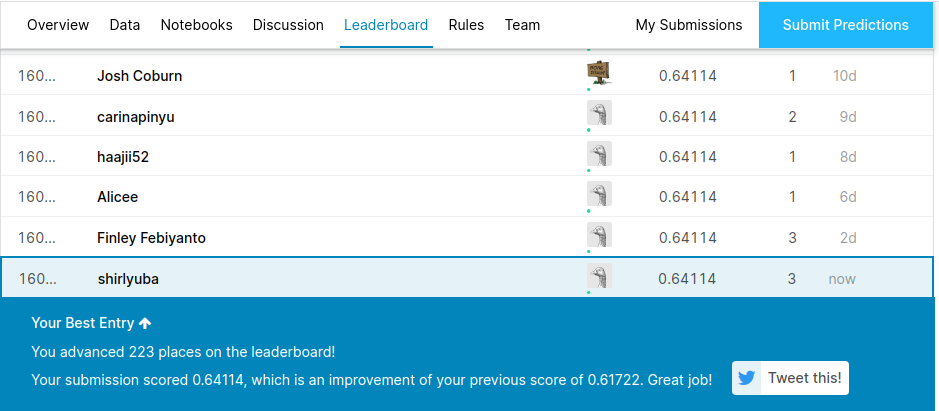